In [143]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import pickle

# plotting 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# data preparation and splitting 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold

# ML models 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# metrics and parameters selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [247]:
df = pd.read_csv('data/Leukemia_GSE28497.csv')

print ('number of samples(patients): %s' % df.shape[0])
print ('number of features(gene probes): %s' % str(df.shape[1]-1))
print ('number of classes(tumour types): %s' % str(df.type.nunique()))

df.head()

number of samples(patients): 281
number of features(gene probes): 22284
number of classes(tumour types): 7


,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM705467.CEL.gz,B-CELL_ALL,7.409521,5.009216,4.173607,7.315369,3.185411,7.620644,3.731541,3.471587,...,2.968822,3.223820,11.968681,12.100004,3.457507,2.967138,2.790814,2.563377,2.860505,2.608381
1,GSM705468.CEL.gz,B-CELL_ALL,7.177109,5.415108,4.426778,7.550818,3.134181,7.685723,3.907953,3.650995,...,2.982888,3.690411,12.318004,12.486741,3.396412,3.109629,2.856499,2.603355,2.908509,2.634063
2,GSM705469.CEL.gz,B-CELL_ALL,6.564918,5.248020,4.252414,7.175169,3.017718,7.956261,3.354557,3.302989,...,2.897425,3.611584,11.748222,11.807578,3.265585,3.057079,2.724642,2.440532,2.626871,2.673293
3,GSM705470.CEL.gz,B-CELL_ALL,6.872028,5.155963,4.388849,7.365933,3.031735,7.830002,3.508926,3.412491,...,3.024722,3.713087,12.208588,12.148604,3.175092,2.896168,2.798296,2.522343,2.762835,2.624163
4,GSM705471.CEL.gz,B-CELL_ALL,7.402105,5.509826,4.284291,7.214947,2.925269,7.789838,3.610425,3.362593,...,3.259802,4.096010,11.641305,11.713311,3.507025,3.119397,2.761294,2.546541,2.748511,2.738165


## Save some data for serving model 

In [275]:
import json

data=df_val.iloc[0].T[2:].to_dict()

with open('B-CELL_ALL_MLL.json', 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(data, f)


data=df_val.iloc[16].T[2:].to_dict()

with open('B-CELL_ALL_HYPO.json', 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(data, f)


data=df_val.iloc[21].T[2:].to_dict()

with open('B-CELL_ALL_HYPERDIP.json', 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(data, f)


data=df_val.iloc[25].T[2:].to_dict()

with open('B-CELL_ALL_ETV6-RUNX1.json', 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(data, f)

data=df_val.iloc[4].T[2:].to_dict()

with open('B-CELL_ALL_T-ALL.json', 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(data, f)

## Class distribution : 7 classes, there is some disbalance

In [9]:
Counter(df.type.tolist())

Counter({'B-CELL_ALL': 74,
         'B-CELL_ALL_ETV6-RUNX1': 53,
         'B-CELL_ALL_HYPERDIP': 51,
         'B-CELL_ALL_T-ALL': 46,
         'B-CELL_ALL_TCF3-PBX1': 22,
         'B-CELL_ALL_HYPO': 18,
         'B-CELL_ALL_MLL': 17})

## Check datatypes: gene expressions are numerical as expected

In [13]:
df.dtypes

samples             object
type                object
1007_s_at          float64
1053_at            float64
117_at             float64
                    ...   
AFFX-ThrX-5_at     float64
AFFX-ThrX-M_at     float64
AFFX-TrpnX-3_at    float64
AFFX-TrpnX-5_at    float64
AFFX-TrpnX-M_at    float64
Length: 22285, dtype: object

In [15]:
Counter(df.dtypes)

Counter({dtype('float64'): 22283, dtype('O'): 2})

## Check missing values: no missing values

In [18]:
df.isnull().sum() 

samples            0
type               0
1007_s_at          0
1053_at            0
117_at             0
                  ..
AFFX-ThrX-5_at     0
AFFX-ThrX-M_at     0
AFFX-TrpnX-3_at    0
AFFX-TrpnX-5_at    0
AFFX-TrpnX-M_at    0
Length: 22285, dtype: int64

In [16]:
Counter(df.isnull().sum()) 

Counter({0: 22285})

## Visualisation: distribution of expression of 3 randomly chosen genes across leukemia subtypes

There is an example of gene with probe '212791_at' that has higher expression in B-CELL_ALL_T-ALL type in comparison to other types 

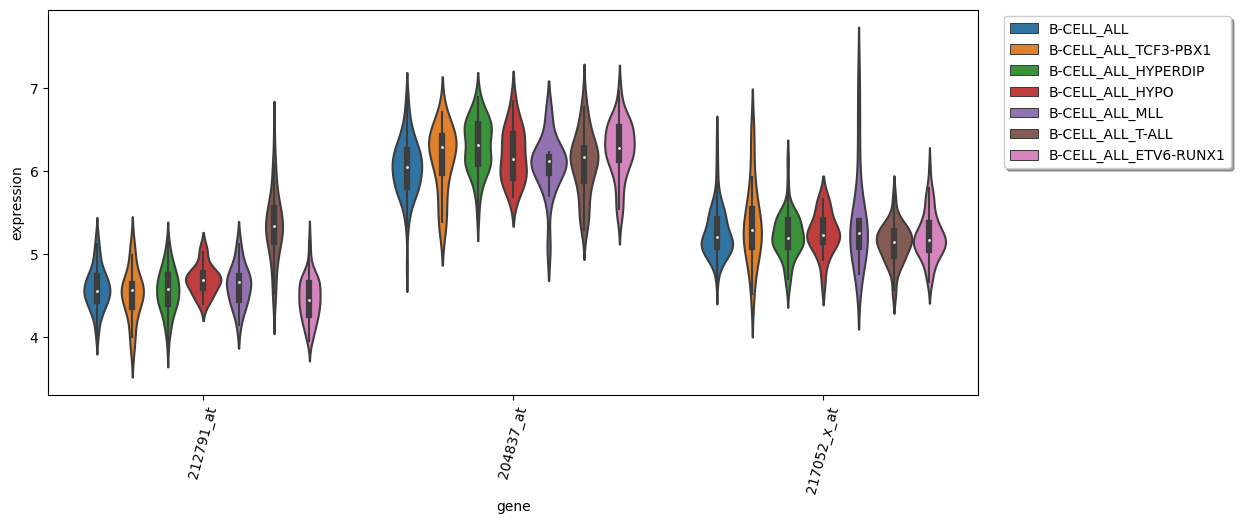

In [34]:
random_subset_of_genes = list(np.random.choice(list(df.columns[2:]), 
                                               size=3, 
                                               replace=False))
subset_df = df[['type', 'samples'] + random_subset_of_genes] 

subset_df_long = pd.melt(subset_df, id_vars=['samples', 'type'], value_vars=random_subset_of_genes, 
                         var_name='gene', value_name='expression')

fig, ax = plt.subplots(figsize=(12,5))


ax = sns.violinplot(data=subset_df_long, x="gene", y="expression", hue='type')

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper center', bbox_to_anchor=(1.15, 1.0),
          ncol=1, fancybox=True, shadow=True)

for tick in ax.get_xticklabels():
    tick.set_rotation(75)

## Clustermap of 1000 randomly selected genes: we can see that expression of some genes are associated with certain leukemia type, but for others it's pretty uniform

/home/alla/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


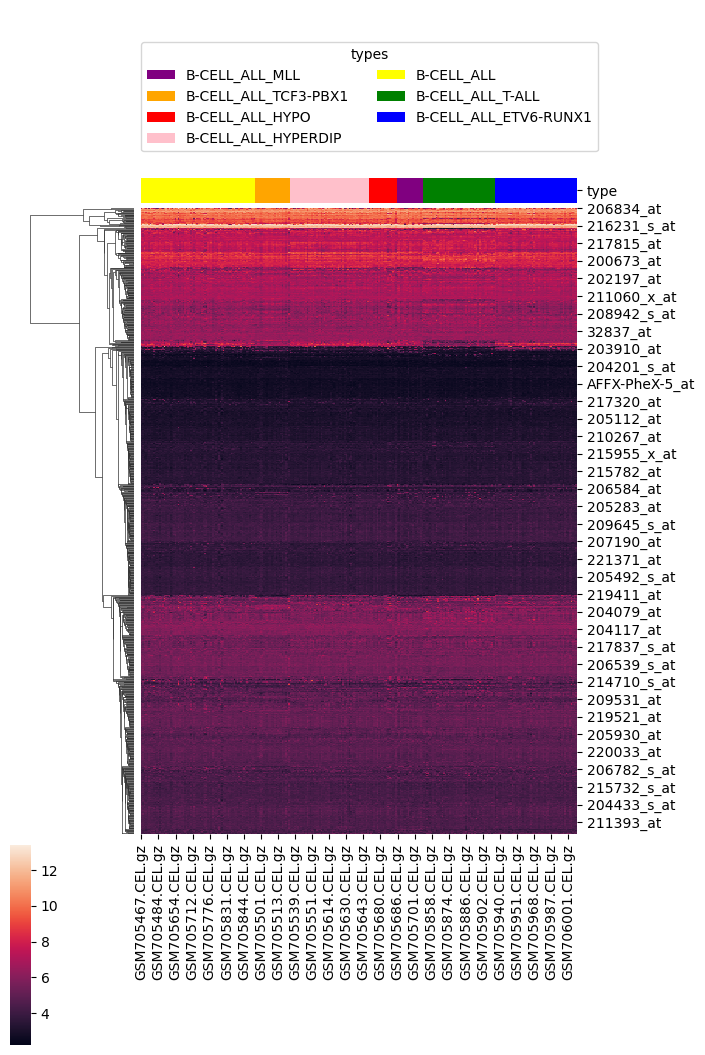

In [108]:
random_subset_of_genes = list(np.random.choice(list(df.columns[2:]), size=1000, replace=False))
subset_df = df[['type', 'samples'] + random_subset_of_genes] 

subset_df_for_clustermap = subset_df[random_subset_of_genes].T
subset_df_for_clustermap.columns = subset_df['samples'].tolist()

pallete = {'B-CELL_ALL':'yellow', 
           'B-CELL_ALL_TCF3-PBX1':'orange', 
           'B-CELL_ALL_HYPERDIP':'pink',
           'B-CELL_ALL_HYPO':'red', 
           'B-CELL_ALL_MLL':'purple', 
           'B-CELL_ALL_T-ALL':'green',
           'B-CELL_ALL_ETV6-RUNX1':'blue'}


col_colors = subset_df.set_index(subset_df_for_clustermap.columns)['type'].map(pallete)

cls = sns.clustermap(
    subset_df_for_clustermap,
    figsize=(7, 10),
    dendrogram_ratio=(.2, .2),
    cbar_pos=(0, -.05, .03, .2),
    col_colors=col_colors,
    col_cluster=False,
    #z_score=1
    #standard_scale=1
)

#plt.setp(cls.ax_heatmap.get_yticklabels(), rotation=360) 


handles = [Patch(facecolor=pallete[name]) for name in lut]
plt.legend(handles, lut, title='types',
           bbox_to_anchor=(0.85, 0.96), ncol=2, bbox_transform=plt.gcf().transFigure)

plt.show()

## Split on train/test/validation 

In [139]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.type.values
y_val = df_val.type.values
y_test = df_test.type.values
y_full_train = df_full_train.type.values

del df_train['type']
del df_val['type']
del df_test['type']
del df_full_train['type']

del df_train['samples']
del df_val['samples']
del df_test['samples']
del df_full_train['samples']

## Scaling numerical values 

In [126]:
X_train = df_train.values
X_test = df_test.values
X_val = df_val.values

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## PCA: number of components explaining the most variation 

In [127]:
def cumulative_explained_variance(variance_vector, percent_of_variance=0.98):
    '''
    find the number of principal components that explin 80% of variance (or other threshold)
    '''
    count = 0
    for i, el in enumerate(variance_vector):
        count += el
        if count >= percent_of_variance:
            number_of_PCA_components = i
            break
    return number_of_PCA_components

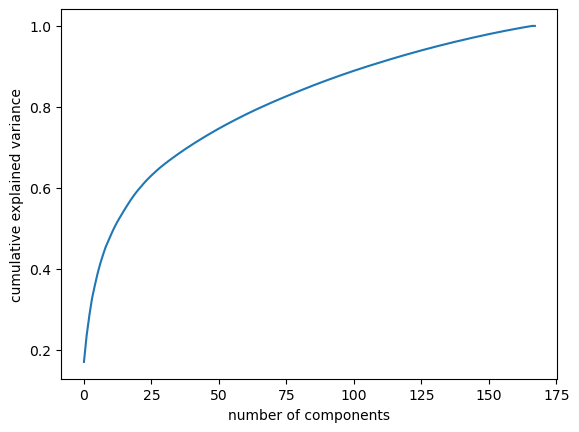

In [128]:
pca = PCA()
pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

In [129]:
# number of components that explain 98% of variance is 151
print (cumulative_explained_variance(pca.explained_variance_ratio_, percent_of_variance=0.98))

151


In [130]:
# number of components that explain 90% of variance is 105
print (cumulative_explained_variance(pca.explained_variance_ratio_, percent_of_variance=0.9))

105


In [182]:
# number of components that explain 80% of variance is 66
print (cumulative_explained_variance(pca.explained_variance_ratio_, percent_of_variance=0.8))

66


In [183]:
# number of components that explain 85% of variance is 85
print (cumulative_explained_variance(pca.explained_variance_ratio_, percent_of_variance=0.85))

85


In [189]:
# number of components that explain 70% of variance is 39
print (cumulative_explained_variance(pca.explained_variance_ratio_, percent_of_variance=0.70))

39


In [185]:
X_train.shape[0]/5

33.6

## Pipelining: scale numerical features, PCA and Multiclass Logistic Regression GridSearch

In [117]:
std_slc = StandardScaler()
pca = PCA()
logistic_Reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)

pipe = Pipeline(steps=[('std_slc', std_slc),
                        ('pca', pca),
                        ('logistic_Reg_Multiclass', logistic_Reg)])

In [193]:
# X_train size is 168 samples 
# number of compoments cannot be more then number of samples 
# there is no point in working with number of components less than 40 (>39 explains more than 70% of variation)
n_components = [40, 50, 70, 90, 100, 105, 120, 130]

C = [0.001,0.005, 0.01, 0.1, 1, 10]

penalty = ['l2']

parameters = dict(pca__n_components=n_components,
                  logistic_Reg_Multiclass__C=C,
                  logistic_Reg_Multiclass__penalty=penalty)

### f1_micro: the contributions of all classes are summed up to compute the average F1

In [194]:
clf_GS = GridSearchCV(pipe, parameters, cv=5, verbose=10, scoring='f1_micro')
    
clf_GS.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40
[CV 1/5; 1/48] END logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40;, score=0.912 total time=   0.4s
[CV 2/5; 1/48] START logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40
[CV 2/5; 1/48] END logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40;, score=0.853 total time=   0.4s
[CV 3/5; 1/48] START logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40
[CV 3/5; 1/48] END logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40;, score=0.882 total time=   0.4s
[CV 4/5; 1/48] START logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40
[CV 4/5; 1/48] END logistic_Reg_Multiclass__C=0.001, l

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA(n_components=70)),
                                       ('logistic_Reg_Multiclass',
                                        LogisticRegression(C=0.001,
                                                           max_iter=2000,
                                                           multi_class='multinomial'))]),
             param_grid={'logistic_Reg_Multiclass__C': [0.001, 0.005, 0.01, 0.1,
                                                        1, 10],
                         'logistic_Reg_Multiclass__penalty': ['l2'],
                         'pca__n_components': [40, 50, 70, 90, 100, 105, 120,
                                               130]},
             scoring='f1_micro', verbose=10)

In [195]:
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg_Multiclass__C'])
    
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
    
print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg_Multiclass'])

Best C: 0.1
Best Number Of Components: 90

LogisticRegression(C=0.1, max_iter=2000, multi_class='multinomial')


In [196]:
pipe = Pipeline(steps=[('std_slc', std_slc),
                        ('pca', pca),
                        ('logistic_Reg_Multiclass', logistic_Reg)])

pipe.set_params(logistic_Reg_Multiclass__penalty='l2', 
                logistic_Reg_Multiclass__C=0.1,
                pca__n_components=90,
                logistic_Reg_Multiclass__max_iter=2000).fit(X_train, y_train).score(X_val, y_val)

0.8035714285714286

### another metric for multiclass problem: 'roc_auc_ovr', ROC AUC for one class vs rest 

In [197]:
clf_GS = GridSearchCV(pipe, parameters, cv=5, verbose=10, scoring='roc_auc_ovr')
    
clf_GS.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40
[CV 1/5; 1/48] END logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40;, score=0.912 total time=   0.4s
[CV 2/5; 1/48] START logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40
[CV 2/5; 1/48] END logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40;, score=0.924 total time=   0.4s
[CV 3/5; 1/48] START logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40
[CV 3/5; 1/48] END logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40;, score=0.953 total time=   0.5s
[CV 4/5; 1/48] START logistic_Reg_Multiclass__C=0.001, logistic_Reg_Multiclass__penalty=l2, pca__n_components=40
[CV 4/5; 1/48] END logistic_Reg_Multiclass__C=0.001, l

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA(n_components=90)),
                                       ('logistic_Reg_Multiclass',
                                        LogisticRegression(C=0.1, max_iter=2000,
                                                           multi_class='multinomial'))]),
             param_grid={'logistic_Reg_Multiclass__C': [0.001, 0.005, 0.01, 0.1,
                                                        1, 10],
                         'logistic_Reg_Multiclass__penalty': ['l2'],
                         'pca__n_components': [40, 50, 70, 90, 100, 105, 120,
                                               130]},
             scoring='roc_auc_ovr', verbose=10)

In [198]:
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg_Multiclass__C'])
    
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
    
print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg_Multiclass'])

Best C: 1
Best Number Of Components: 130

LogisticRegression(C=1, max_iter=2000, multi_class='multinomial')


In [199]:
pipe = Pipeline(steps=[('std_slc', std_slc),
                        ('pca', pca),
                        ('logistic_Reg_Multiclass', logistic_Reg)])

pipe.set_params(logistic_Reg_Multiclass__penalty='l2', 
                logistic_Reg_Multiclass__C=1,
                pca__n_components=130,
                logistic_Reg_Multiclass__max_iter=2000).fit(X_train, y_train).score(X_val, y_val)

0.8214285714285714

## Final model: scores on validation

In [200]:
pipe = Pipeline(steps=[('std_slc', std_slc),
                        ('pca', pca),
                        ('logistic_Reg_Multiclass', logistic_Reg)])

pipe.set_params(logistic_Reg_Multiclass__penalty='l2', 
                logistic_Reg_Multiclass__C=1,
                pca__n_components=130,
                logistic_Reg_Multiclass__max_iter=2000).fit(X_train, y_train).score(X_val, y_val)

0.8392857142857143

## Crossvalidation mean and std scores on full train dataset

In [201]:
X_full_train = df_full_train.values

In [204]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(pipe, X_full_train, y_full_train, scoring='roc_auc_ovr', cv=cv, n_jobs=-1, )

print('roc_auc_ovr: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

roc_auc_ovr: 0.952 (0.036)


## Confusion matrix on validation 

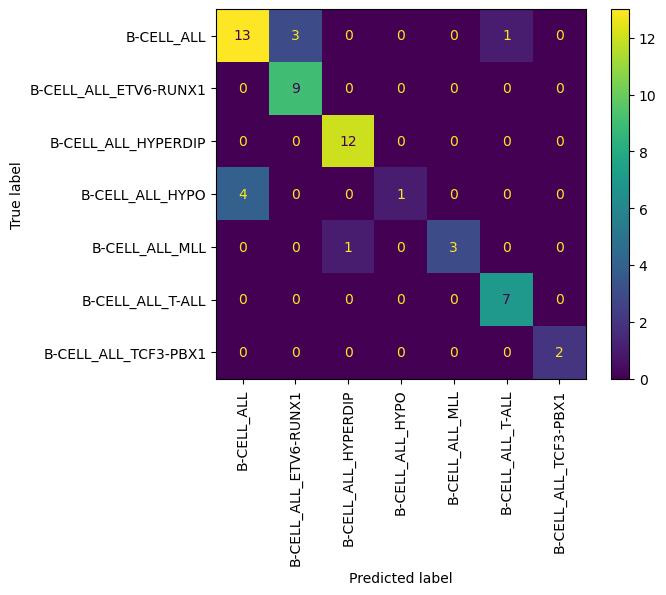

In [205]:
y_pred = pipe.predict(X_val)

cm = confusion_matrix(y_val, y_pred,  labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()

plt.xticks(rotation = 90)
plt.show()

## Use model with final params of full train (train+test)

In [212]:
def train(df_train, y_train, l='l2', C=1.0, pca_components=130):
    '''
    create a pipeline 
    train logistic regression 
    '''
    std_slc = StandardScaler()
    pca = PCA()
    logistic_Reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)

    pipe = Pipeline(steps=[('std_slc', std_slc),
                        ('pca', pca),
                        ('logistic_Reg_Multiclass', logistic_Reg)])


    pipe.set_params(logistic_Reg_Multiclass__penalty=l, 
                logistic_Reg_Multiclass__C=C,
                pca__n_components=pca_components,
                logistic_Reg_Multiclass__max_iter=2000)

    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    pipe.set_params(logistic_Reg_Multiclass__penalty='l2', 
                logistic_Reg_Multiclass__C=0.01,
                pca__n_components=105,
                logistic_Reg_Multiclass__max_iter=2000).fit(X_train, y_train)

    return dv, pipe

In [229]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)#[:, 1]

    return y_pred

In [234]:
dv, model = train(df_full_train, y_full_train, C=1.0)

y_pred = predict(df_val, dv, model)

In [296]:
pipe.classes_

array(['B-CELL_ALL', 'B-CELL_ALL_ETV6-RUNX1', 'B-CELL_ALL_HYPERDIP',
       'B-CELL_ALL_HYPO', 'B-CELL_ALL_MLL', 'B-CELL_ALL_T-ALL',
       'B-CELL_ALL_TCF3-PBX1'], dtype=object)

In [297]:
di = {0:'B-CELL_ALL', 
      1:'B-CELL_ALL_ETV6-RUNX1', 
      2:'B-CELL_ALL_HYPERDIP',
      3:'B-CELL_ALL_HYPO', 
      4:'B-CELL_ALL_MLL', 
      5:'B-CELL_ALL_T-ALL',
      6:'B-CELL_ALL_TCF3-PBX1'}

y_classes = list(map(di.get, y_pred.argmax(axis=-1)))

y_classes[0:4]

['B-CELL_ALL_MLL',
 'B-CELL_ALL_HYPERDIP',
 'B-CELL_ALL_HYPERDIP',
 'B-CELL_ALL_HYPERDIP']

In [238]:
micro_roc_auc_ovr = roc_auc_score(
    y_val,
    y_pred,
    multi_class="ovr",
    average="micro",
)

micro_roc_auc_ovr

1.0

In [240]:
# Save the model

output_file = "model.bin"

with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)